# Symbolic Regression on real data
## Use the GEP-RNC algorithm with the UCI Power Plant dataset  
In this example, we aim to test how well GEP-RNC works solving machine learning problems over real data. The dataset we will use is the UCI Power Plant dataset:

https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant

This task requires us to predict the **Power Output** of a power plant given the environmental variables of:
**Atmospheric Temperature**, **Exhaust Vacuum Speed**, **Atmospheric Pressure**, and **Relative Humidity**.

This is a typical machine learning regression problem which we will try and evolve using *Gene Expression Programming with Random Numerical Constants*.

https://en.wikipedia.org/wiki/Gene_expression_programming

## Notes
Places to get familiar with GEP and *geppy* are here:

+ [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html)
+ [Overview of geppy for Gene Expression Programming (GEP)](https://geppy.readthedocs.io/en/latest/overview.html)

To check the detailed documentation of each function/class in *geppy*, please refer to [library reference](https://geppy.readthedocs.io/en/latest/#library-reference).

** Be advised this example is a revision of the original example at:**

https://github.com/ShuhuaGao/geppy/blob/master/examples/sr/numerical_expression_inference-RNC.ipynb

originally created by **Shuhua Gao**

# Code:

In [1]:
import geppy as gep
from deap import creator, base, tools
import numpy as np
import random

import operator 
import math
import datetime

# for reproduction
s = 0
random.seed(s)
np.random.seed(s)

In [2]:
import pandas as pd

In [3]:
import os

#doublecheck the data is there
print(os.listdir("../../data/."))

['UCI_PowerPlant.csv']


In [4]:
# read in the data to pandas
PowerPlantData = pd.read_csv("../../data/UCI_PowerPlant.csv")

## Notes on the ML training data

The UCI power plant data is a common ML benchmarking dataset.
Although [it is available on their website](https://archive.ics.uci.edu/ml/datasets/combined+cycle+power+plant) I am actually grabbing a cache of the data from github where a really good exploratory data analysis was done, found here: https://github.com/YungChunLu/UCI-Power-Plant. 

The file layout for the data is:
```
AT = Atmospheric Temperature in C
V = Exhaust Vacuum Speed
AP = Atmospheric Pressure
RH = Relative Humidity
PE = Power Output               # This is the Target variable for regression problems
```

Using the power plant morning variables, can we predict `PE`, the end of day power produced?

In [5]:
PowerPlantData.describe()

,AT,V,AP,RH,PE
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


## Split my data into Train and Test chunks, 20/80

In [6]:
msk = np.random.rand(len(PowerPlantData)) < 0.8
train = PowerPlantData[msk]
holdout = PowerPlantData[~msk]

In [7]:
# check the number of records we'll validate our MSE with
holdout.describe()

,AT,V,AP,RH,PE
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,19.616097,54.356172,1013.299260,73.505078,454.396038
std,7.465892,12.826614,5.817991,14.565070,17.116266
min,2.800000,25.360000,995.020000,31.290000,421.570000
25%,13.410000,41.760000,1009.290000,63.290000,439.920000
50%,20.510000,52.050000,1012.920000,75.140000,451.750000
75%,25.680000,67.070000,1017.070000,85.080000,469.100000
max,35.100000,80.180000,1033.250000,100.130000,495.210000


In [8]:
# check the number of records we'll train our algorithm with
train.describe()

,AT,V,AP,RH,PE
count,7703.000000,7703.000000,7703.000000,7703.000000,7703.000000
mean,19.659738,54.293609,1013.249350,73.261499,454.357497
std,7.449681,12.679790,5.967993,14.609326,17.056150
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.535000,41.685000,1009.050000,63.340000,439.720000
50%,20.320000,52.080000,1012.950000,74.910000,451.500000
75%,25.720000,66.500000,1017.290000,84.750000,468.275000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


In [9]:
# copy and convert our pandas dataframe into numpy variables.
# I will leave the target at Y, as I can't see where to set that in the code, but it's in there somehow!

# NOTE: I'm only feeding in the TRAIN values to the algorithms. Later I will independely check
# the MSE myself using a holdout test dataset

AT = train.AT.values
V  = train.V.values
AP = train.AP.values
RH = train.RH.values

Y = train.PE.values  # this is our target, now mapped to Y

print(AT)
print(V)
print(AP)
print(RH)
print(Y)

[ 8.34 23.64 29.74 ... 33.41 15.99 17.65]
[40.77 58.49 56.9  ... 77.95 43.34 59.87]
[1010.84 1011.4  1007.15 ... 1010.3  1014.2  1018.58]
[90.01 74.2  41.91 ... 59.72 78.66 94.65]
[480.48 445.75 438.76 ... 432.9  465.96 450.93]


# Creating the primitives set
The first step in GEP (or GP as well) is to specify the primitive set, which contains the elementary building blocks to formulate the model. For this problem, we have:
+ function set: the standard arithmetic operators addition (+), subtraction (-), multiplication (*), and division (/).
+ terminal set: only the single input 'x' and random numerical constants (RNC).

NOTE:

- We define a *protected division* to avoid dividing by zero.
- Even there may be multiple RNCs in the model, we only need to call `PrimitiveSet.add_rnc` once.

In [10]:
def protected_div(x1, x2):
    if abs(x2) < 1e-6:
        return 1
    return x1 / x2

# Map our input data to the GEP variables
Here we map the input data to the GEP algorithm:

We do that by listing the field names as "input_names".

In reviewing geppy code, in the file:  
  geppy/geppy/core/symbol.py
  
we find how terminals in the gene are named correctly to match input data.

Oh - notice, I only mapped in below the input data columes, and not the TARGET "PE" which is sitting in var Y.
I didn't notice where to map that - so suggest you force the target variable to "Y" when reading in data.

In [11]:
pset = gep.PrimitiveSet('Main', input_names=['AT','V','AP','RH'])

# Define the operators
Here we define and pass the operators we'll construct our final symbolic regression function with

In [12]:
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
pset.add_function(protected_div, 2)
pset.add_function(math.sin, 1)        # I tested adding my own functions
pset.add_function(math.cos, 1)
pset.add_function(math.tan, 1)
pset.add_rnc_terminal()

# Create the individual and population
Our objective is to **minimize** the MSE (mean squared error) for data fitting.
## Define the indiviudal class, a subclass of *gep.Chromosome*

In [13]:
from deap import creator, base, tools

creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

## Register the individual and population creation operations
In DEAP, it is recommended to register the operations used in evolution into a *toolbox* to make full use of DEAP functionality. The configuration of individuals in this problem is:
+ head length: 6
+ number of genes in each chromosome: 2
+ RNC array length: 8

Generally, more complicated problems require a larger head length and longer chromosomes formed with more genes. **The most important is that we should use the `GeneDc` class for genes to make use of the GEP-RNC algorithm.**

# Your Core Settings Defined Here

In [14]:
h = 8          # head length
n_genes = 2    # number of genes in a chromosome
r = 10         # length of the RNC array

**NOTE** Above you define the gene structure which sets out the maximum complexity of the symbolic regression

In [15]:
toolbox = gep.Toolbox()
toolbox.register('rnc_gen', random.randint, a=-10, b=10)   # each RNC is random integer within [-5, 5]
toolbox.register('gene_gen', gep.GeneDc, pset=pset, head_length=h, rnc_gen=toolbox.rnc_gen, rnc_array_length=r)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# Define the fitness evaluation function
In DEAP, the single objective optimization problem is just a special case of more general multiobjective ones. Since *geppy* is built on top of DEAP, it conforms to this convention. **Even if the fitness only contains one measure, keep in mind that DEAP stores it as an iterable.** 

Knowing that, you can understand why the evaluation function must return a tuple value (even if it is a 1-tuple). That's also why we set ``weights=(-1,)`` when creating the ``FitnessMax`` class.

In [16]:
# as a test I'm going to try and accelerate the fitness function
from numba import jit

@jit
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
    
    # below call the individual as a function over the inputs
    
    # Yp = np.array(list(map(func, X)))
    Yp = np.array(list(map(func, AT, V, AP, RH))) 
    
    # return the MSE as we are evaluating on it anyway - then the stats are more fun to watch...
    return np.mean((Y - Yp) ** 2),

            

In [17]:
toolbox.register('evaluate', evaluate)

# Register genetic operators
Compared with GP and other genetic algorithms, GEP has its own set of genetic operators aside from common mutation and crossover. For details, please check the tutorial [Introduction to gene expression programming](https://geppy.readthedocs.io/en/latest/intro_GEP.html).

In the following code, the selection operator is ``tools.selTournament`` provided by DEAP, while all other operators are specially designed for GEP in *geppy*.

In [18]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.3)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
# 2. Dc-specific operators
toolbox.register('mut_dc', gep.mutate_uniform_dc, ind_pb=0.05, pb=1)
toolbox.register('mut_invert_dc', gep.invert_dc, pb=0.1)
toolbox.register('mut_transpose_dc', gep.transpose_dc, pb=0.1)
# for some uniform mutations, we can also assign the ind_pb a string to indicate our expected number of point mutations in an individual
toolbox.register('mut_rnc_array_dc', gep.mutate_rnc_array_dc, rnc_gen=toolbox.rnc_gen, ind_pb='0.5p')
toolbox.pbs['mut_rnc_array_dc'] = 1  # we can also give the probability via the pbs property

# Statistics to be inspected
We often need to monitor of progress of an evolutionary program. DEAP offers two classes to handle the boring work of recording statistics. Details are presented in [Computing statistics](http://deap.readthedocs.io/en/master/tutorials/basic/part3.html). In the following, we are intereted in the average/standard deviation/min/max of all the individuals' fitness in each generation.

In [19]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# Launch evolution
We make use of *geppy*'s builtin algorithm ``gep_rnc`` here to perform the GEP-RNC evolution. A special class from DEAP, `HallOfFame`, is adopted to store the best individuals ever found. Besides, it should be noted that in GEP [*elitism*](https://en.wikipedia.org/wiki/Genetic_algorithm#Elitism) is highly recommended because some genetic operators in GEP are destructive and may destroy the best individual we have evolved.

In [20]:
# size of population and number of generations
n_pop = 60
n_gen = 2000

#100 3000

champs = 3

pop = toolbox.population(n=n_pop)
hof = tools.HallOfFame(champs)   # only record the best three individuals ever found in all generations


In [21]:
startDT = datetime.datetime.now()
print (str(startDT))

2019-01-06 00:52:54.995381


In [22]:
# start evolution
pop, log = gep.gep_simple(pop, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof, verbose=True)

gen	nevals	avg        	std        	min   	max        
0  	60    	1.19494e+09	8.04795e+09	101729	6.27346e+10
1  	59    	1.76185e+10	1.34577e+11	95519.9	1.05131e+12
2  	59    	157134     	208662     	65344.2	1.74613e+06
3  	59    	1.28112e+06	8.50917e+06	65344.2	6.65903e+07
4  	59    	161696     	327463     	65344.2	2.64592e+06
5  	59    	471014     	2.7328e+06 	65344.2	2.14564e+07
6  	59    	1.24259e+08	6.7549e+08 	56656  	4.29246e+09
7  	59    	1.5591e+06 	8.89745e+06	56656  	6.66884e+07
8  	59    	332131     	1.80495e+06	33602.1	1.41783e+07
9  	59    	87217.3    	69414.5    	33602.1	474219     
10 	59    	97272.3    	95765      	28953.4	498333     
11 	59    	326536     	1.74258e+06	28953.4	1.36391e+07
12 	59    	2.12894e+06	1.22266e+07	27079.8	9.06836e+07
13 	59    	1.07899e+08	8.19279e+08	14031.4	6.40056e+09
14 	59    	2.20604e+06	1.14201e+07	12415.1	6.65216e+07
15 	59    	306493     	1.79238e+06	12415.1	1.40435e+07
16 	59    	336475     	1.85873e+06	12415.1	1.45689e+07
17 	59    	3

In [23]:
print ("Evolution times were:\n\nStarted:\t", startDT, "\nEnded:   \t", str(datetime.datetime.now()))

Evolution times were:

Started:	 2019-01-06 00:52:54.995381 
Ended:   	 2019-01-06 03:30:00.469757


**Let's check the best individuals ever evolved.**

In [24]:
print(hof[0])

add(
	protected_div(V, -10),
	protected_div(AT, protected_div(AT, sub(add(protected_div(AP, 2), -8), add(AT, AT))))
)


# Present our Work and Conclusions

## Symbolic simplification of the final solution
The symbolic tree answer may contain many redundancies, for example, `protected_div(x, x)` is just 1. We can perform symbolic simplification of the final result by `geppy.simplify` which depends on `sympy` package. We can also leverage sympy to better present our work to others

In [25]:
# print the best symbolic regression we found:
best_ind = hof[0]
symplified_best = gep.simplify(best_ind)

key= '''
Given training examples of

    AT = Atmospheric Temperature (C)
    V = Exhaust Vacuum Speed
    AP = Atmospheric Pressure
    RH = Relative Humidity

we trained a computer using Genetic Algorithms to predict the 

    PE = Power Output

Our symbolic regression process found the following equation offers our best prediction:

'''

print('\n', key,'\t', str(symplified_best), '\n\nwhich formally is presented as:\n\n')

from sympy import *
init_printing()
symplified_best

# use   str(symplified_best)   to get the string of the symplified model


 
Given training examples of

    AT = Atmospheric Temperature (C)
    V = Exhaust Vacuum Speed
    AP = Atmospheric Pressure
    RH = Relative Humidity

we trained a computer using Genetic Algorithms to predict the 

    PE = Power Output

Our symbolic regression process found the following equation offers our best prediction:

 	 AP/2 - 2*AT - V/10 - 8 

which formally is presented as:




In [26]:
# output the top 3 champs
#champs = 3
#for i in range(champs):
#    ind = hof[i]
#    symplified_model = gep.simplify(ind)
#
#    print('\nSymplified best individual {}: '.format(i))
#    print(symplified_model)
#    print("raw indivudal:")
#    print(hof[i])

In [27]:
 # we want to use symbol labels instead of words in the tree graph
rename_labels = {'add': '+', 'sub': '-', 'mul': '*', 'protected_div': '/'}  
gep.export_expression_tree(best_ind, rename_labels, 'data/numerical_expression_tree.png')

As we can see from the above simplified expression, the *truth model* has been successfully found. Due to the existence of Gaussian noise, the minimum mean absolute error （MAE) is still not zero even the best individual represents the true model.

## Visualization
If you are interested in the expression tree corresponding to the individual, i.e., the genotype/phenotype system, *geppy* supports tree visualization by the `graph` and the `export_expression_tree` functions:

- `graph` only outputs the nodes and links information to describe the tree topology, with which you can render the tree with tools you like;
- `export_expression_tree` implements tree visualization with data generated by `graph` internally using the `graphviz` package. 

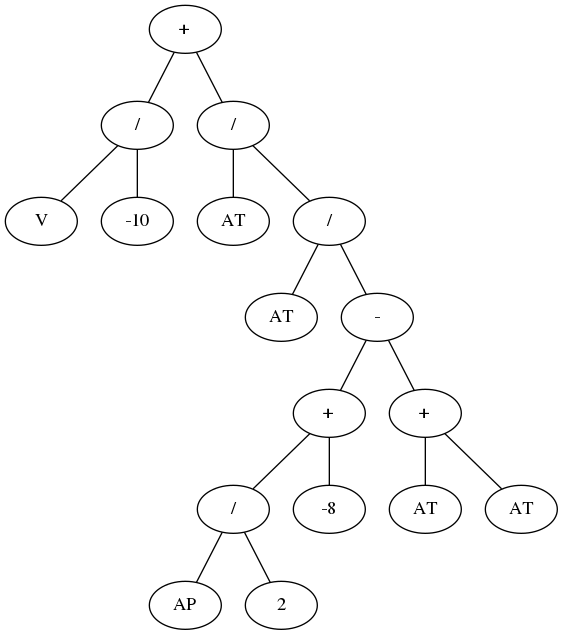

In [28]:
 # show the above image here for convenience
from IPython.display import Image
Image(filename='data/numerical_expression_tree.png')

# DoubleCheck our final Test Statistics
Earlier, we split our data into train and test chunks.

The GEPPY program never saw 20% of our data, so lets doublecheck the reported errors on our holdout test file are accurate:


In [29]:
def CalculateBestModelOutput(AT, V, AP, RH, model):
    # pass in a string view of the "model" as str(symplified_best)
    # this string view of the equation may reference any of the other inputs, AT, V, AP, RH we registered
    # we then use eval of this string to calculate the answer for these inputs
    return eval(model) 

# some previous example outputs
# (AT*(AP - 2*AT - V - 23) + 4*V)/(2*AT)       # MSE 23.5 is my best run.
# AP/2 - AT - V/2 - 8.0 + RH/(2*AT)            # MSE 26 # also a very good run.

# other results with worse performance on short/small runs were
# (AP*(3*AT + 1) + AT*V*(AP + AT + 2*RH)/3)/(AT*V)
# AP/2 - AT - V/2 - 6


In [30]:
holdout.describe()

,AT,V,AP,RH,PE
count,1865.000000,1865.000000,1865.000000,1865.000000,1865.000000
mean,19.616097,54.356172,1013.299260,73.505078,454.396038
std,7.465892,12.826614,5.817991,14.565070,17.116266
min,2.800000,25.360000,995.020000,31.290000,421.570000
25%,13.410000,41.760000,1009.290000,63.290000,439.920000
50%,20.510000,52.050000,1012.920000,75.140000,451.750000
75%,25.680000,67.070000,1017.070000,85.080000,469.100000
max,35.100000,80.180000,1033.250000,100.130000,495.210000


In [31]:
predPE = CalculateBestModelOutput(holdout.AT, holdout.V, holdout.AP, holdout.RH, str(symplified_best))

In [32]:
predPE.describe()

count    1865.000000
mean      453.981820
std        17.669401
min       416.776000
25%       439.204000
50%       451.836000
75%       469.233000
max       492.798000
dtype: float64

In [33]:
predPE.head()

7     469.874
8     427.674
13    476.491
17    474.777
19    441.835
dtype: float64

## Validation MSE:

In [34]:
from sklearn.metrics import mean_squared_error, r2_score
print("Mean squared error: %.2f" % mean_squared_error(holdout.PE, predPE))
print("R2 score : %.2f" % r2_score(holdout.PE, predPE))

Mean squared error: 28.77
R2 score : 0.90


### Let's eyeball predicted vs actual data:

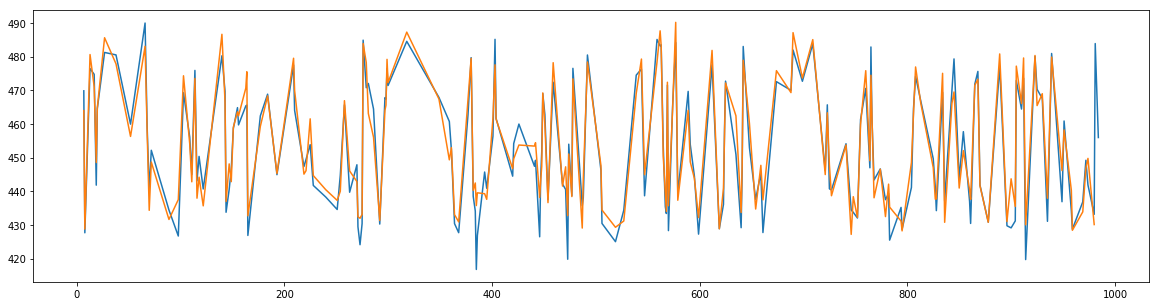

In [39]:
from matplotlib import pyplot
pyplot.rcParams['figure.figsize'] = [20, 5]
plotlen=200
pyplot.plot(predPE.head(plotlen))       # predictions are in blue
pyplot.plot(holdout.PE.head(plotlen-2)) # actual values are in orange
pyplot.show()


### Histogram of prediction Errors on the holdout dataset:

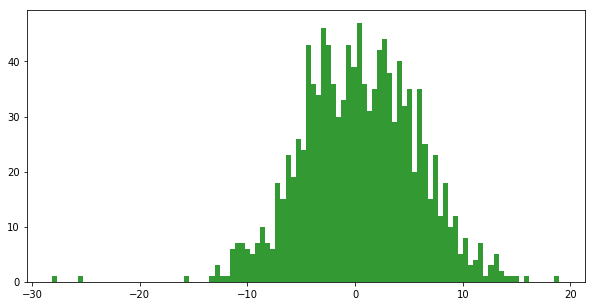

In [36]:
plotlen=1200
pyplot.rcParams['figure.figsize'] = [10, 5]
hfig = pyplot.figure()
ax = hfig.add_subplot(111)

numBins = 100
ax.hist(holdout.PE.head(plotlen)-predPE.head(plotlen),numBins,color='green',alpha=0.8)
pyplot.show()

### Is it worth implementing the answer?
Deploying ML solutions to production can often be expensive. Doing nothing is invariably the alternative to a spending money delivering ML produced models into production. It implies a "business case" question we should answer when we conclude the study:
If the business people selling the power plant outputs resorted to a common impulse to use the "average output" of the plant over the time period to be the "estimate" of plant output - what would this very low cost alternative look like? How would using Machine Learning improve the business over and above what they would see as the cheapest strategy?
#### how bad is the simple estimate, versus our found solution?
Let's examine the histogram of errors of the alternative "do nothing" approach to estimation.

### Simple averages are not great
The simple average approach gives us a plus/minus 40 on the value, which is not bell curve shaped, meaning the business will feel the estimates are generally poor most of the time.
In contrast, our symbolic regression gives us a nice bell curve shaped estimate, that is plus/minus 14 on a particularly bad day, and otherwise plus/minus 8 ... so a far far better estimate.



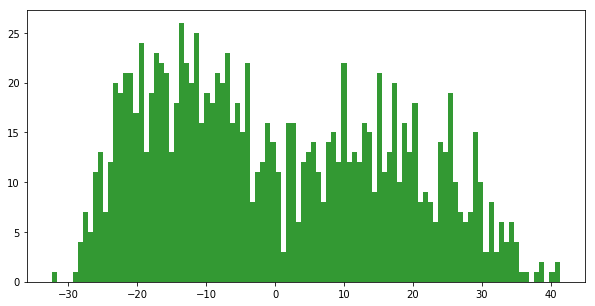

In [37]:
hfig2 = pyplot.figure()
ax = hfig2.add_subplot(111)

numBins = 100
ax.hist(holdout.PE.head(plotlen)-holdout.PE.head(plotlen).mean(),numBins,color='green',alpha=0.8)
#ax.hist(holdout.PE.head(plotlen)-predPE.head(plotlen),numBins,color='orange',alpha=0.8)
pyplot.show()

# Business Value
Let's compare the cheapest solution (using average value) against our solution, having roughtly similar cost

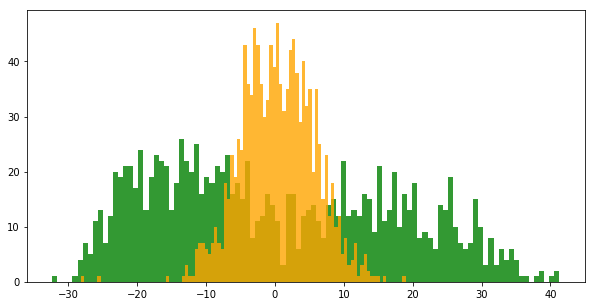

In [38]:
hfig3 = pyplot.figure()
ax = hfig3.add_subplot(111)

numBins = 100
ax.hist(holdout.PE.head(plotlen)-holdout.PE.head(plotlen).mean(),numBins,color='green',alpha=0.8)
ax.hist(holdout.PE.head(plotlen)-predPE.head(plotlen),numBins,color='orange',alpha=0.8)
pyplot.show()

### Next Steps: Implementation
The implementation cost of getting our symbolic regression based estimator into production is very very low as a general rule of thumb. 

This is because the regression equation can be quickly re-written into any target system or programming language imaginable very quickly. The complete model portability of the equations produced are a huge benefit of the method.

In the power plant for example, they could simply add this equation into the spreadsheet where they are maintaining the raw data to get this benefit. 

### Footnotes:

License: **MIT**

Update: **Jan 6th, 2019**

Author: ** Andrew Morgan**

About the Author:

Andrew is a big data engineer and data scientist. He currently works as a director in the ACIA (Aon Centre of Innovation and Analytics) where he is is the Head of Data Services, based in Dublin, Krakow, and London. He is also the author of **Mastering Spark for Data Science**) found here https://www.amazon.co.uk/Mastering-Spark-Science-Andrew-Morgan/dp/1785882147 and is the owner of ByteSumo, a big data science consultancy.
